In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Import Data

In [4]:
#Import Dataset
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)

            volatility      index  crash_label  price_change  volume_change  \
date                                                                          
1998-03-31   -0.628541  000001.SS            0      0.187709      -0.127147   
1998-06-30   -0.628541  000001.SS            0      0.504913      -0.127147   
1998-09-30   -0.625680  000001.SS            1     -0.795446      -0.127147   
1998-12-31   -0.631403  000001.SS            0     -0.843210      -0.127147   
1999-03-31   -0.629515  000001.SS            0     -0.082838      -0.127147   
...                ...        ...          ...           ...            ...   
2018-12-31   -0.493234      ^SSMI            0     -0.800378      -0.127147   
2019-03-31   -0.529809      ^SSMI            0      0.914383      -0.127147   
2019-06-30   -0.458321      ^SSMI            0      0.217264      -0.127147   
2019-09-30   -0.388212      ^SSMI            0     -0.010617      -0.127147   
2019-12-31   -0.351813      ^SSMI            0      

# Build the model

In [6]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {'max_depth':[3,5,7], 'n_estimators':[50,100,200,1000], 'learning_rate':[0.1,0.01,0.001]}
        grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]

    # Train the model
    model = xgb.XGBClassifier(max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_e

[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.1s
[CV] END .learning_rate=0.01, max_depth=7, n_estimators=1000; total time=   0.2s
[CV] END .learning_rate=0.01, max_depth=7, n_estimators=1000; total time=   0.4s
[CV] END .learning_rate=0.01, max_depth=7, n_estimators=1000; total time=   0.4s
[CV] END .learning_rate=0.01

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   0.2s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0

[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=1000; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=1000; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=1000; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=1000; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=1000; total time=   0.6s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.0

[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=   0.4s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=   0.3s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=   0.3s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=   0.3s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.0

[CV] END learning_rate=0.001, max_depth=5, n_estimators=1000; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=1000; total time=   0.6s
[CV] END ..learning_rate=0.001, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=7, n_estimators=50; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=7, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.00

In [7]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[63, 5], [2, 0]]",0.000000,0.000000,0.000000,...,0.104017,0.024024,0.020089,0.084651,0.078829,0.022036,0.052974,0.0,0.015761,0.066282
1,1998-03-31,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[29, 13], [8, 20]]",0.606061,0.714286,0.655738,...,0.056238,0.031984,0.055699,0.071905,0.042683,0.025047,0.074315,0.0,0.027813,0.052372
2,1998-03-31,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[54, 10], [0, 6]]",0.375000,1.000000,0.545455,...,0.030110,0.030253,0.046108,0.067421,0.051394,0.051758,0.098815,0.0,0.041034,0.030296
3,1998-03-31,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[52, 7], [2, 9]]",0.562500,0.818182,0.666667,...,0.020436,0.022348,0.046474,0.042589,0.042270,0.050489,0.089618,0.0,0.024516,0.041170
4,1998-03-31,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[55, 14], [0, 1]]",0.066667,1.000000,0.125000,...,0.039875,0.023223,0.049687,0.081687,0.038147,0.050233,0.077991,0.0,0.034211,0.031806


## Shap Values

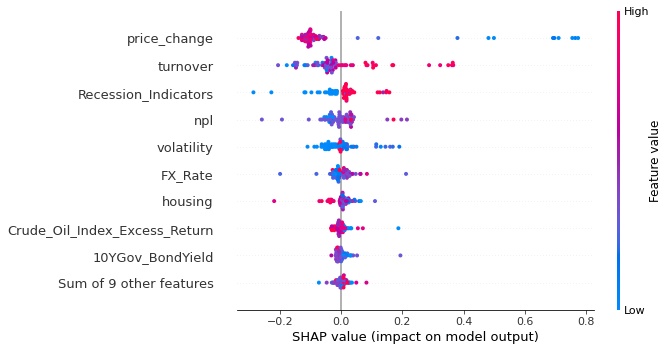

In [8]:
shap.plots.beeswarm(shap_values_list[4])

# Feature Importance

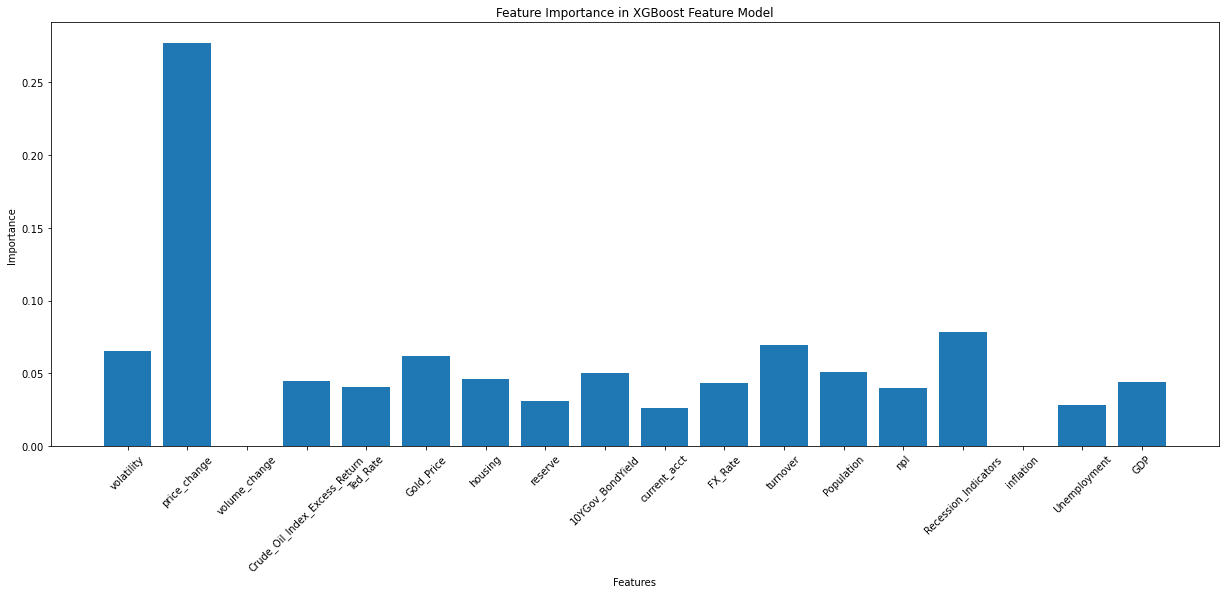

In [9]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [10]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8029671103803617


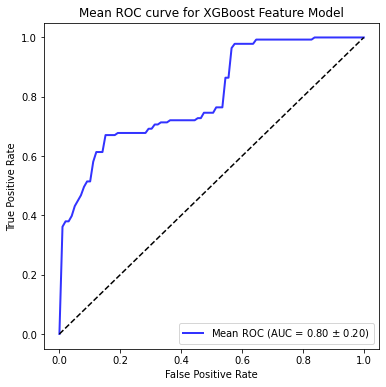

In [11]:
plot_roc_curve(evaluation_df, model_name)

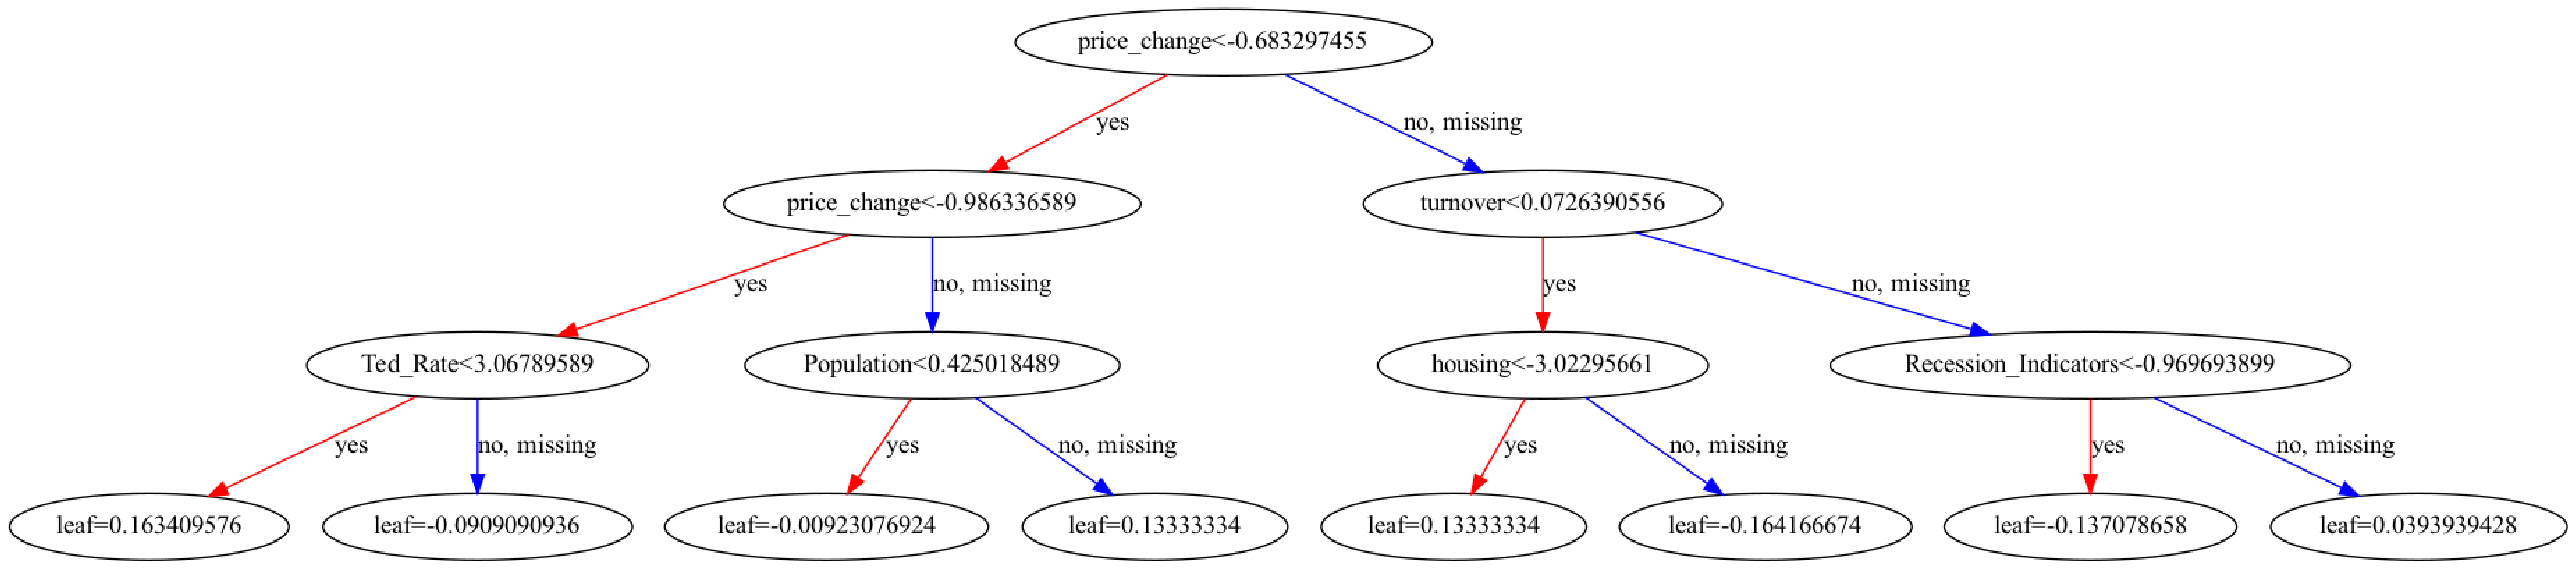

In [18]:
# pip install graphviz
fig, ax = plt.subplots(figsize=(170, 170))
xgb.plot_tree(model, ax=ax)
plt.show()